In [1]:
# Getting imports
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mplfinance as mpf
from sklearn.metrics import accuracy_score, classification_report
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [5]:
# Load data
df = pd.read_csv("UNIONBANK__EQ__NSE__NSE__MINUTE.csv", parse_dates=["timestamp"])

# Convert to daily data
df["date"] = df["timestamp"].dt.date
daily_df = df.groupby("date").agg({
    "open": "first",  # First value of the day
    "close": "last",   # Last value of the day
    "volume": "sum",   # Total volume
})

# Create target column (next day's movement)
daily_df["Next_Close"] = daily_df["close"].shift(-1)  # Future close price
daily_df["Target"] = (daily_df["Next_Close"] > daily_df["close"]).astype(int)  # 1=Up, 0=Down

# Drop last row (no future data for it)
daily_df = daily_df[:-1]

In [6]:
# Prepare input data (X = past N days, Y = next day's movement)
N_DAYS = 30  # Use last 10 days to predict next day
X, Y = [], []

for i in range(len(daily_df) - N_DAYS):
    X.append(daily_df.iloc[i:i+N_DAYS, :-2].values)  # Features
    Y.append(daily_df.iloc[i+N_DAYS]["Target"])      # Label

import numpy as np
X, Y = np.array(X), np.array(Y)

# Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(N_DAYS, X.shape[2])),
    LSTM(50),
    Dense(1, activation="sigmoid")  # Binary classification (Up/Down)
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

# Train model
model.fit(X, Y, epochs=10, batch_size=16, validation_split=0.2)



Epoch 1/10


c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.5545 - loss: 0.6886 - val_accuracy: 0.5389 - val_loss: 0.6902
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5682 - loss: 0.6872 - val_accuracy: 0.4611 - val_loss: 0.7038
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5188 - loss: 0.6936 - val_accuracy: 0.5389 - val_loss: 0.6903
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5824 - loss: 0.6857 - val_accuracy: 0.5389 - val_loss: 0.6916
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5403 - loss: 0.6919 - val_accuracy: 0.5389 - val_loss: 0.6903
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5440 - loss: 0.6906 - val_accuracy: 0.5389 - val_loss: 0.6903
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5701 - loss: 0.6880 - val_accuracy: 0.5389 - val_loss: 0.6905
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5038 - loss: 0.6950 - val_accuracy: 0.5389 - val_loss: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Predicted movement: Stock will go DOWN tomorrow.
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Training Accuracy: 0.5400624349635796

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      1.00      0.70       519
         1.0       0.00      0.00      0.00       442

    accuracy                           0.54       961
   macro avg       0.27      0.50      0.35       961
weighted avg       0.29      0.54      0.38       961



c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\charl\OneDrive\Documents\GitHub\AI-stock-price-prediction\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` param

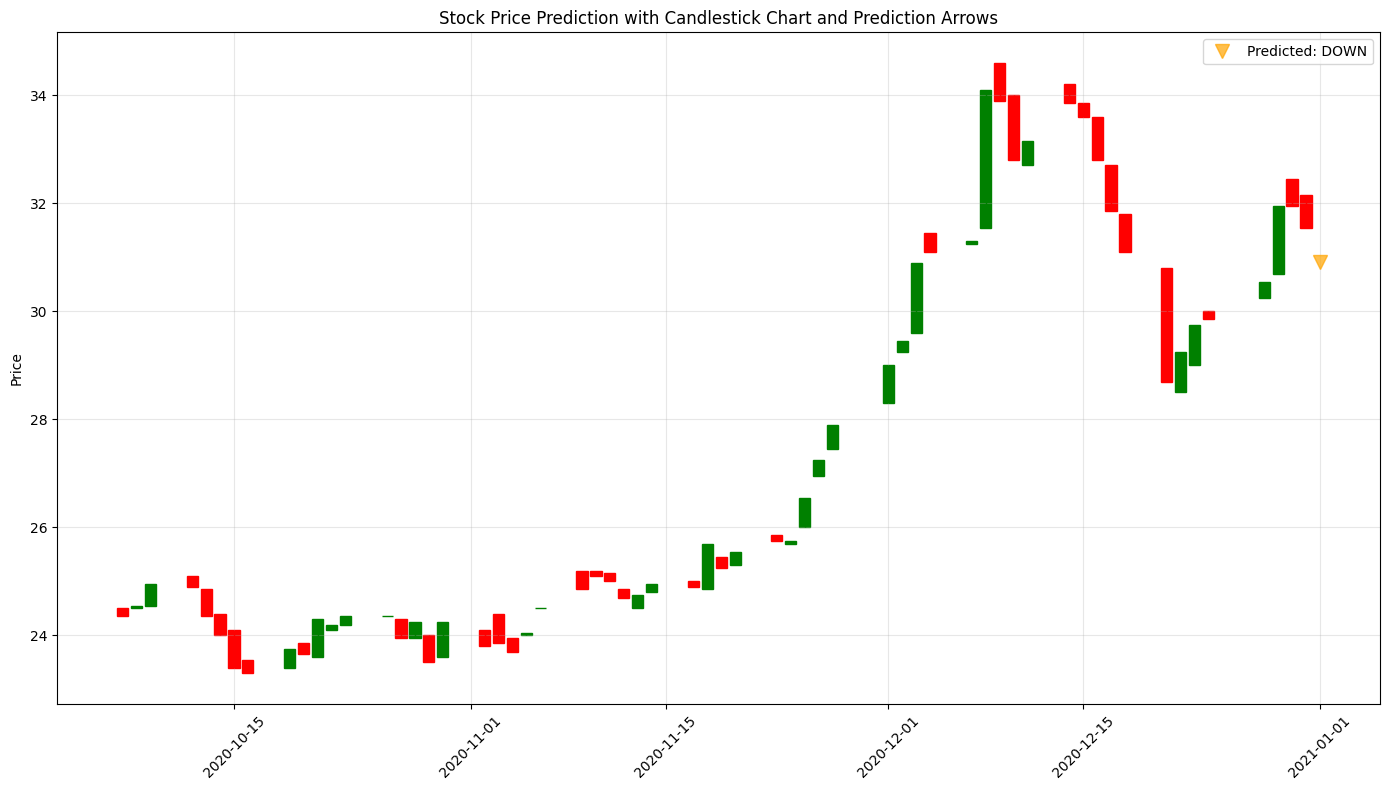

In [7]:
last_N_days = daily_df.iloc[-N_DAYS:, :-2].values.reshape(1, N_DAYS, -1)
prediction = model.predict(last_N_days)

predicted_movement = "UP" if prediction > 0.5 else "DOWN"
print(f"Predicted movement: Stock will go {predicted_movement} tomorrow.")

train_predictions = (model.predict(X) > 0.5).astype(int).flatten()

# Calculate accuracy and classification report
accuracy = accuracy_score(Y, train_predictions)
report = classification_report(Y, train_predictions)

print(f"Training Accuracy: {accuracy}")
print("\nClassification Report:")
print(report)

# Modify candlestick visualization to include arrows for predictions
fig, ax = plt.subplots(figsize=(14, 8))

# Plot candlesticks for the last 60 days
candlestick_data = daily_df.iloc[-60:]
for date, row in candlestick_data.iterrows():
    if row["close"] >= row["open"]:
        color = "green"
        bottom = row["open"]
        height = row["close"] - row["open"]
    else:
        color = "red"
        bottom = row["close"]
        height = row["open"] - row["close"]

    ax.add_patch(Rectangle(
        (mdates.date2num(date) - 0.4, bottom),
        0.8, height,
        facecolor=color,
        edgecolor=color
    ))
    ax.vlines(date, row["open"], row["close"], color=color, linewidth=1.0)

# Add prediction arrow for the next day
last_close = candlestick_data["close"].iloc[-1]
arrow_color = "blue" if predicted_movement == "UP" else "orange"
arrow_direction = "^" if predicted_movement == "UP" else "v"
arrow_y = last_close * 1.02 if predicted_movement == "UP" else last_close * 0.98

ax.plot(
    mdates.date2num(candlestick_data.index[-1] + pd.Timedelta(days=1)),
    arrow_y,
    arrow_direction,
    color=arrow_color,
    markersize=10,
    alpha=0.7,
    label=f"Predicted: {predicted_movement}"
)

# Formatting
ax.set_title("Stock Price Prediction with Candlestick Chart and Prediction Arrows")
ax.set_ylabel("Price")
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Show the chart
plt.show()

In [4]:
# Predict the next day's movement using the last N days of data
last_N_days = daily_df.iloc[-N_DAYS:, :-2].values.reshape(1, N_DAYS, -1)
prediction = model.predict(last_N_days)

predicted_movement = "UP" if prediction > 0.5 else "DOWN"
print(f"Predicted movement: Stock will go {predicted_movement} tomorrow.")

# Plot the candlestick chart for the last 60 days
candlestick_data = daily_df.iloc[-60:]  # Last 60 days for visualization

fig = go.Figure(data=[
    go.Candlestick(
        x=candlestick_data.index,
        open=candlestick_data["open"],
        high=candlestick_data["close"],  # Assuming high is not available, using close
        low=candlestick_data["open"],   # Assuming low is not available, using open
        close=candlestick_data["close"],
        name="Stock Prices"
    )
])

# Add a marker for the predicted movement
fig.add_trace(go.Scatter(
    x=[candlestick_data.index[-1] + pd.Timedelta(days=1)],  # Next day
    y=[candlestick_data["close"].iloc[-1]],  # Last close price
    mode="markers+text",
    marker=dict(color="red" if predicted_movement == "DOWN" else "green", size=10),
    text=[f"Predicted: {predicted_movement}"],
    textposition="top center",
    name="Prediction"
))

# Update layout
fig.update_layout(
    title="Stock Price Prediction with Candlestick Chart",
    xaxis_title="Date",
    yaxis_title="Price",
    xaxis_rangeslider_visible=False
)

# Show the chart
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Predicted movement: Stock will go DOWN tomorrow.
